# Setup

In [857]:
import numpy as np
import matplotlib.pyplot as plt

In [2360]:
def fftnoise(f, just_phase=False):
    # adapted from frank-zalkow's Stack Overflow answer
    # https://stackoverflow.com/questions/33933842/how-to-generate-noise-in-frequency-range-with-numpy
    assert len(f) % 2 == 0  # let's just work with even sample sizes for now
    f = np.array(np.sqrt(f), dtype="complex")
    Np = (len(f) - 1) // 2
    rng = np.random.default_rng()
    if just_phase:
        phases = np.exp(2j * np.pi * rng.uniform(size=Np))
        f[1:Np+1] *= phases
        f[-1:-(1 + Np):-1] = np.conj(f[1:Np+1])
    else:
        reals = rng.standard_normal(Np) / np.sqrt(2)
        ims = rng.standard_normal(Np) / np.sqrt(2)
        f[1:Np+1] *= (reals + 1j * ims)
        f[Np+1] *= rng.standard_normal() / np.sqrt(2)  # Nyquist frequency must be real for even sample sizes
        f[-1:-(1 + Np):-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f, norm="ortho").real[1:] # zero-mean

In [2185]:
def lorentzian(f, std, f0, y):
    return (std * y)**2 / ((f - f0)**2 + y**2)

def pink(f, std, rolloff=0):
    f1 = np.abs(f)
    indx1 = np.where(f1 <= rolloff)
    indx2 = np.where(f1 > rolloff)
    f1[indx1] = std**2
    f1[indx2] = std**2 * min(f1[indx2]) / (f1[indx2] + 1)
    return f1

def brown(f, std, rolloff=0):
    f1 = np.abs(f)
    indx1 = np.where(f1 <= rolloff)
    indx2 = np.where(f1 > rolloff)
    f1[indx1] = std**2
    print(min(f1[indx2]))
    f1[indx2] = (std * min(f1[indx2]))**2 / (f1[indx2]**2)
    return f1

def prune(array, min_value, max_value):
    idxlow = np.where(array < min_value)[0]
    idxhigh = np.where(array > max_value)[0]
    array[idxhigh] = max_value
    array[idxlow] = min_value
    return array

In [2319]:
def generate_lorentzian_noise(s0, f0, y, min_value=-1e10, max_value=1e10, samples=1024, samplerate=1/2e-6, just_phase=False):
    freqs = np.fft.fftfreq(int(samples), 1/samplerate)
    rfreqs = np.fft.rfftfreq(int(samples), 1/samplerate)[1:]
    f = lorentzian(freqs, s0, f0, y)
    return rfreqs, f[:len(rfreqs)], prune(fftnoise(f, just_phase=just_phase), min_value, max_value)

def generate_pink_noise(s0, rolloff=0, min_value=-1e10, max_value=1e10, samples=1024, samplerate=1/2e-6, just_phase=False):
    freqs = np.fft.fftfreq(int(samples), 1/samplerate)
    rfreqs = np.fft.rfftfreq(int(samples), 1/samplerate)[1:]
    f = pink(freqs, s0, rolloff=rolloff)
    return rfreqs, f[:len(rfreqs)], prune(fftnoise(f, just_phase=just_phase), min_value, max_value)

def generate_brown_noise(s0, rolloff=0, min_value=-1e10, max_value=1e10, samples=1024, samplerate=1/2e-6, just_phase=False):
    freqs = np.fft.fftfreq(int(samples), 1/samplerate)
    rfreqs = np.fft.rfftfreq(int(samples), 1/samplerate)[1:]
    f = brown(freqs, s0, rolloff=rolloff)
    return rfreqs, f[:len(rfreqs)], prune(fftnoise(f, just_phase=just_phase), min_value, max_value)

def generate_white_noise(s0, min_value=-1e10, max_value=1e10, min_freq=-1e-10, max_freq=1e10, samples=1024, samplerate=1/2e-6, just_phase=False):
    freqs = np.fft.fftfreq(int(samples), 1/samplerate)
    rfreqs = np.fft.rfftfreq(int(samples), 1/samplerate)[1:]
    f = np.zeros(int(samples))
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = (s0 / 2)**2  # because zero-mean
    return rfreqs, f[:len(rfreqs)], prune(fftnoise(f, just_phase=just_phase), min_value, max_value)

# Lorentzian

## Randomness just on the phase

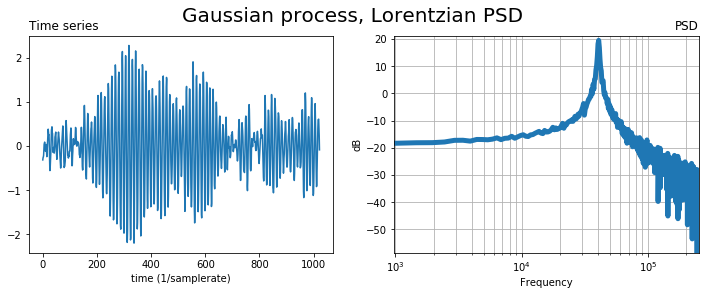

0.792260119409936
9.45963917703104


In [2362]:
std = 10
f0 = 4e4
gamma = 5e2
freqs, f, b = generate_lorentzian_noise(std, f0, gamma, just_phase=True)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(range(len(b)), b)
ax[0].set_title("Time series", loc="left")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.rfft(b, norm="ortho"))**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=5)
ax[1].set_ylim(10 * np.log10([min(pamps), max(pamps) * 1.5]))
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].grid(True, which="both")
ax[1].set_ylabel("dB")
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
plt.suptitle("Gaussian process, Lorentzian PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(max(pamps)))

## Randomness on phase and amplitude of Fourier components

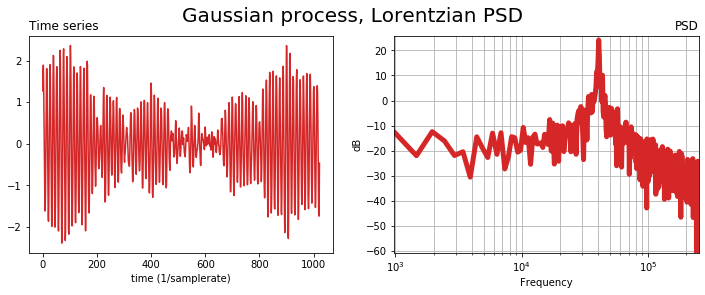

0.9308414434153836
16.123967743023798


In [2363]:
std = 10
f0 = 4e4
gamma = 5e2
freqs, f, b = generate_lorentzian_noise(std, f0, gamma, just_phase=False)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(range(len(b)), b, color="C3")
ax[0].set_title("Time series", loc="left")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.rfft(b, norm="ortho"))**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=5, color="C3")
ax[1].set_ylim(10 * np.log10([min(pamps), max(pamps) * 1.5]))
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].grid(True, which="both")
ax[1].set_ylabel("dB")
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
plt.suptitle("Gaussian process, Lorentzian PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(max(pamps)))

# Pink

## Randomness just on the phase

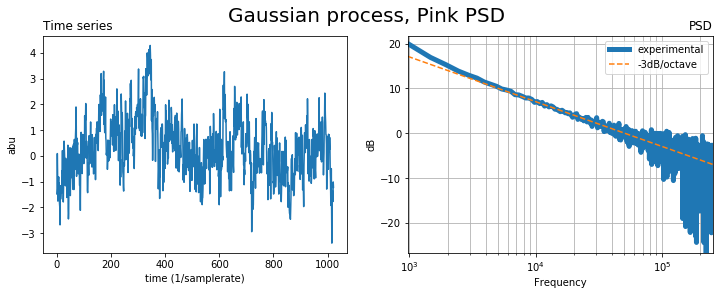

1.1523842731725318
10.056851665464496


In [2364]:
std = 10
samples = 1024
rolloff = 0
freqs, f, b = generate_pink_noise(std, rolloff=rolloff, samples=samples, just_phase=True)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(np.arange(len(b)), b)
ax[0].set_title("Time series", loc="left")
ax[0].set_ylabel("abu")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.rfft(b, norm="ortho"))**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=5, label="experimental")
ax[1].semilogx(freqs, 10 * np.log10( max(pamps) * 500 / (freqs + 1)), ls="dashed", label="-3dB/octave")
ax[1].set_ylim(10 * np.log10([min(pamps), max(pamps) * 1.5]))
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].grid(True, which="both")
ax[1].set_ylabel("dB")
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
ax[1].legend()
plt.suptitle("Gaussian process, Pink PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(max(pamps)))

## Randomness on phase and amplitude of Fourier components

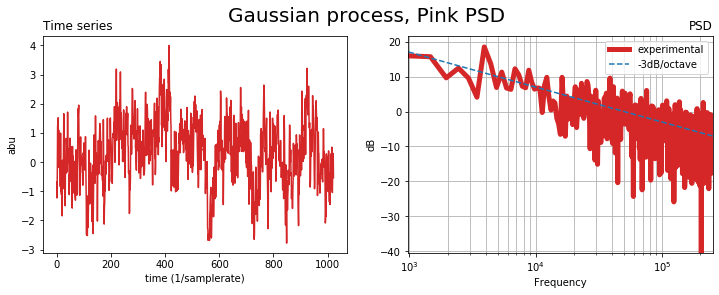

1.1029123288712317
10.006990135851467


In [2365]:
std = 10
samples = 1024
rolloff = 0
freqs, f, b = generate_pink_noise(std, rolloff=rolloff, samples=samples, just_phase=False)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(np.arange(len(b)), b, color="C3")
ax[0].set_title("Time series", loc="left")
ax[0].set_ylabel("abu")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.rfft(b, norm="ortho"))**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=5, label="experimental", color="C3")
ax[1].semilogx(freqs, 10 * np.log10( max(pamps) * 500 / (freqs + 1)), ls="dashed", label="-3dB/octave")
ax[1].set_ylim(10 * np.log10([min(pamps), max(pamps) * 1.5]))
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].grid(True, which="both")
ax[1].set_ylabel("dB")
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
ax[1].legend()
plt.suptitle("Gaussian process, Pink PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(max(pamps)))

# White

## Randomness just on the phase

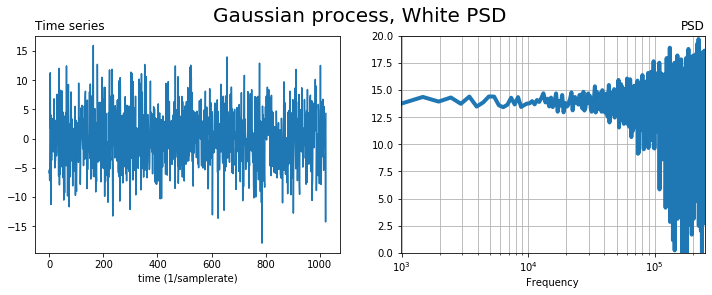

4.991317252430607
9.638722433460542


In [2366]:
std = 10
samples = 1024
freqs, f, b = generate_white_noise(std, samples=samples, just_phase=True)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(range(len(b)), b)
ax[0].set_title("Time series", loc="left")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.rfft(b, norm="ortho"))**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=4)
ax[1].set_ylim(0, 20)
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
ax[1].grid(True, which="both")
plt.suptitle("Gaussian process, White PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(np.max(pamps)))

## Randomness on phase and amplitude of Fourier components

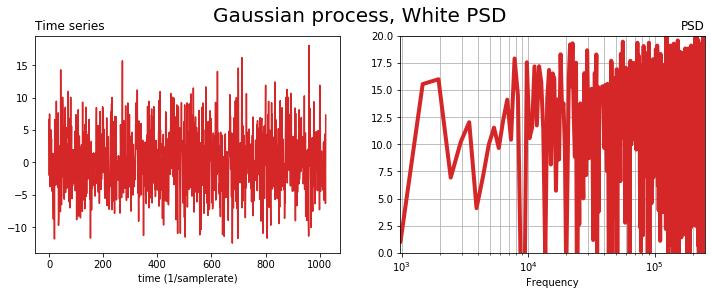

4.858272992021588
11.652156584824974


In [2367]:
std = 10
samples = 1024
freqs, f, b = generate_white_noise(std, samples=samples, just_phase=False)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(range(len(b)), b, color="C3")
ax[0].set_title("Time series", loc="left")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.rfft(b, norm="ortho"))**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=4, color="C3")
ax[1].set_ylim(0, 20)
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
ax[1].grid(True, which="both")
plt.suptitle("Gaussian process, White PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(np.max(pamps)))

# Brown

## Randomness just on the phase

488.28125


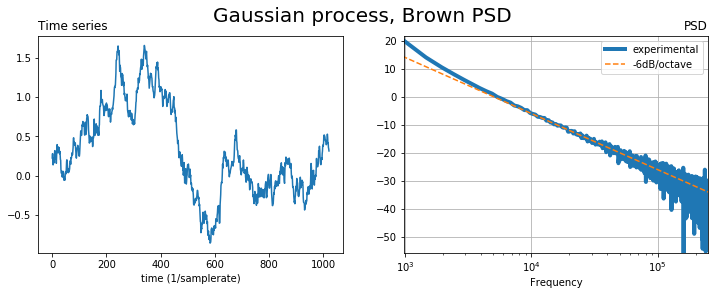

0.5667501283990023
10.003968514910829


In [2368]:
std = 10
rolloff = 0
freqs, f, b = generate_brown_noise(std, rolloff=rolloff, samples=1024, just_phase=True)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(range(len(b)), b)
ax[0].set_title("Time series", loc="left")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.rfft(b, norm="ortho"))**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=4, label="experimental")
ax[1].semilogx(freqs, 10 * np.log10( max(pamps) * 500**2 / (freqs**2 + 1)), ls="dashed", label="-6dB/octave")
ax[1].set_ylim(10 * np.log10([min(pamps), max(pamps) * 1.5]))
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
ax[1].grid(True)
ax[1].legend()
plt.suptitle("Gaussian process, Brown PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(np.max(pamps)))

## Randomness on phase and amplitude of Fourier components

488.28125


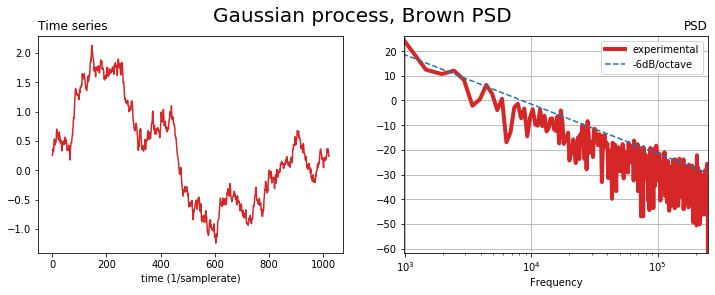

0.8307001141087412
16.848420265272384


In [2369]:
std = 10
rolloff = 0
freqs, f, b = generate_brown_noise(std, rolloff=rolloff, samples=1024, just_phase=False)

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(range(len(b)), b, color="C3")
ax[0].set_title("Time series", loc="left")
ax[0].set_xlabel("time (1/samplerate)")
pamps = np.abs(np.fft.rfft(b, norm="ortho"))**2
ax[1].semilogx(freqs, 10 * np.log10(pamps), lw=4, label="experimental", color="C3")
ax[1].semilogx(freqs, 10 * np.log10( max(pamps) * 500**2 / (freqs**2 + 1)), ls="dashed", label="-6dB/octave")
ax[1].set_ylim(10 * np.log10([min(pamps), max(pamps) * 1.5]))
ax[1].set_xlim(freqs[1], freqs[-1])
ax[1].set_xlabel("Frequency")
ax[1].set_title("PSD", loc="right")
ax[1].grid(True)
ax[1].legend()
plt.suptitle("Gaussian process, Brown PSD", fontsize=20)
plt.show()
print(np.std(b))
print(np.sqrt(np.max(pamps)))